In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analysis_functions import Analysis

# 1) Hyperparameter search and model working

First, I tried to get the 4-qubit UQC model to work by doing a hyperparameter search over the target network update frequency and the number of layers:
 - Target Network Update Frequency: [100,250]
 - Number of Layers: [7,10,15]

The next was the best performing model I got with 250 and 15 for the two hyperparameters, respectively.

I forgot to store the models with this, so I am going to do it now.

# 2) Data Encoding

It is important to note that thiis environment has a discrete state space composed of 6 features:
- Cosine of the first joint angle (theta1): [-1,1]
- Sine of the first joint angle (theta1): [-1,1]
- Cosine of the second joint angle (theta2): [-1,1]
- Sine of the second joint angle (theta2): [-1,1]
- Angular velocity of the first joint (theta1_dot): [-4pi,4pi]
- Angular velocity of the second joint (theta2_dot): [-9pi,9pi]

Up until now, I was simply doing ContinuousEncoding, which consists of applying the arctan function to each of the features and then using the resultant value as the angle to the rotations. As I am writing this, I am realizing this all might not make a lot of sense for the UQC model, because the angle rotation is given by the dot product between the input vector and the weight vector plus a bias. Still, this might not make a lot of sense because, for once it doesnt make much sence to use the arctan of cosines and sines. So, I tried a couple of different methods of data encoding and I will show the results below.

Types of encoding I will experiment with:

- ScaledEncoding: Every feature is scaled to be between 0 and 2pi
- AcrobotEncoding: Every feature is normalized to be between -1 and 1
- AcrobotEncodingV2: First, I reduce the state-space size dimsensionality from 6 to 4 by calculating theta1 and theta2 and using those values instead of the cossines and sines of each of them. Then, i normalized the angular velocities to be between 0 and 2pi.

This is all for the 4-qubit UQC models.

In [2]:
scaled_encoding_path = "../../results/acrobot_best/acrobot_best1_with_scaled_encoding"
acrobot_encoing_path = "../../results/acrobot_best/acrobot_best1_with_acrobot_encoding"
acrobot_encoding_v2_path = "../../results/acrobot_best/acrobot_best1_with_acrobot_encodingv2"

scaled_encoding = Analysis(scaled_encoding_path)
acrobot_encoding = Analysis(acrobot_encoing_path)
acrobot_encoding_v2 = Analysis(acrobot_encoding_v2_path)

In [3]:
scaled_encoding_return = scaled_encoding.get_rewards()
acrobot_encoding_return = acrobot_encoding.get_rewards()
acrobot_encoding_v2_return = acrobot_encoding_v2.get_rewards()

scaled_encoding_mean = np.mean(scaled_encoding_return, axis=0)
acrobot_encoding_mean = np.mean(acrobot_encoding_return, axis=0)
acrobot_encoding_v2_mean = np.mean(acrobot_encoding_v2_return, axis=0)

scaled_encoding_std = np.std(scaled_encoding_return, axis=0)
acrobot_encoding_std = np.std(acrobot_encoding_return, axis=0)
acrobot_encoding_v2_std = np.std(acrobot_encoding_v2_return, axis=0)

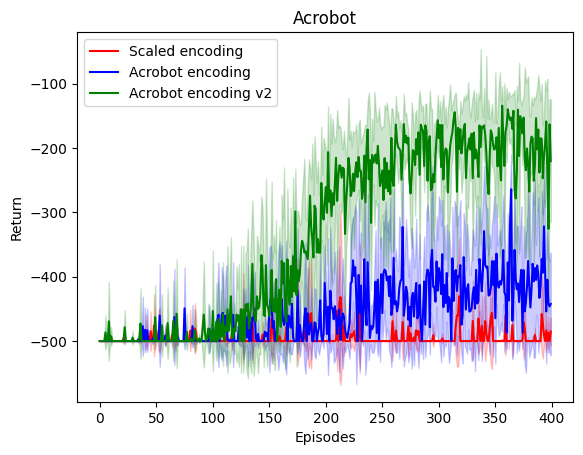

In [4]:
plt.plot(scaled_encoding_mean,color = "red", label="Scaled encoding")
plt.fill_between(np.arange(len(scaled_encoding_mean)), scaled_encoding_mean - scaled_encoding_std, scaled_encoding_mean + scaled_encoding_std,color = "red", alpha=0.2)

plt.plot(acrobot_encoding_mean,color = "blue", label="Acrobot encoding")
plt.fill_between(np.arange(len(acrobot_encoding_mean)), acrobot_encoding_mean - acrobot_encoding_std, acrobot_encoding_mean + acrobot_encoding_std,color = "blue", alpha=0.2)

plt.plot(acrobot_encoding_v2_mean,color = "green", label="Acrobot encoding v2")
plt.fill_between(np.arange(len(acrobot_encoding_v2_mean)), acrobot_encoding_v2_mean - acrobot_encoding_v2_std, acrobot_encoding_v2_mean + acrobot_encoding_v2_std,color = "green", alpha=0.2)

plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Acrobot")
plt.show()

We can clearly see that acrobot encoding v2 reaches a good level of performance. On the other hand, scaled encoding models learn basically nothing whatsoever, and acrobot encoding models learn a little bit, but not a lot and the performance still isnt that good.

Maybe to see the difference we can use another metric, the Area Under The curve (AUC) of the reward curve, and the smaller it is the better the performance of the model, since the rewards are negative.

In [5]:
def auc(results):
        results_mean = np.mean(results, axis=0)
        area = np.abs(np.trapz(results_mean))
        maximum_performance_area = float(len(results[0]) * 500)

        # Now we want to create a metric called performance area and normalize it between 0 and 1
        performance_area = area / maximum_performance_area
        return performance_area

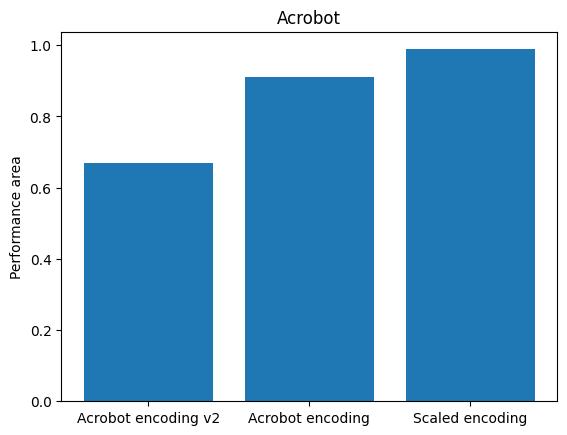

In [6]:
performance_scaled_encoding = auc(scaled_encoding_return)
performance_acrobot_encoding = auc(acrobot_encoding_return)
performance_acrobot_encoding_v2 = auc(acrobot_encoding_v2_return)

performance_models = [performance_scaled_encoding, performance_acrobot_encoding, performance_acrobot_encoding_v2]
models_names = ["Scaled encoding", "Acrobot encoding", "Acrobot encoding v2"]

performance_moldes_sorted = np.sort(performance_models)
models_names_sorted = [models_names[i] for i in np.argsort(performance_models)]

plt.bar(models_names_sorted, performance_moldes_sorted)
plt.ylabel("Performance area")
plt.title("Acrobot")
plt.show()


The closer to zero the better, and we can see that acrobot encoding v2 is the best performing model.

# 3) Hyperparameter Details

Clearly the acrobot-v2 encoding is learning something and the other types of encoding are not. Thus, I am going to focus on that encoding and try to make small adjusts to the other hyperparameters to see if I can get a better performance.

The hyperparameters I am going to try to adjust are:
 - 1) learning rate: 0.001 -> 0.0001
 - 2) epsilon_min: 0.01 -> 0.001
 - 3) target_network_update_freq: 250 -> 100
 - 4) replay_memory_size: 10000 -> 50000

In [7]:
learning_rate_path = "../../results/acrobot_best/acrobot_best1_with_acrobot_encodingv2_test1"
epsilon_min_path = "../../results/acrobot_best/acrobot_best1_with_acrobot_encodingv2_test2"
target_update_path = "../../results/acrobot_best/acrobot_best1_with_acrobot_encodingv2_test3"
replay_buffer_path = "../../results/acrobot_best/acrobot_best1_with_acrobot_encodingv2_test4"

learning_rate = Analysis(learning_rate_path)
epsilon_min = Analysis(epsilon_min_path)
target_update = Analysis(target_update_path)
replay_buffer = Analysis(replay_buffer_path)

Now let's compare each one of these models with the original one and see if any of them improve the performance.

In [8]:
learning_rate_return = learning_rate.get_rewards()
epsilon_min_return = epsilon_min.get_rewards()
target_update_return = target_update.get_rewards()
replay_buffer_return = replay_buffer.get_rewards()

learning_rate_mean = np.mean(learning_rate_return, axis=0)
epsilon_min_mean = np.mean(epsilon_min_return, axis=0)
target_update_mean = np.mean(target_update_return, axis=0)
replay_buffer_mean = np.mean(replay_buffer_return, axis=0)

learning_rate_std = np.std(learning_rate_return, axis=0)
epsilon_min_std = np.std(epsilon_min_return, axis=0)
target_update_std = np.std(target_update_return, axis=0)
replay_buffer_std = np.std(replay_buffer_return, axis=0)

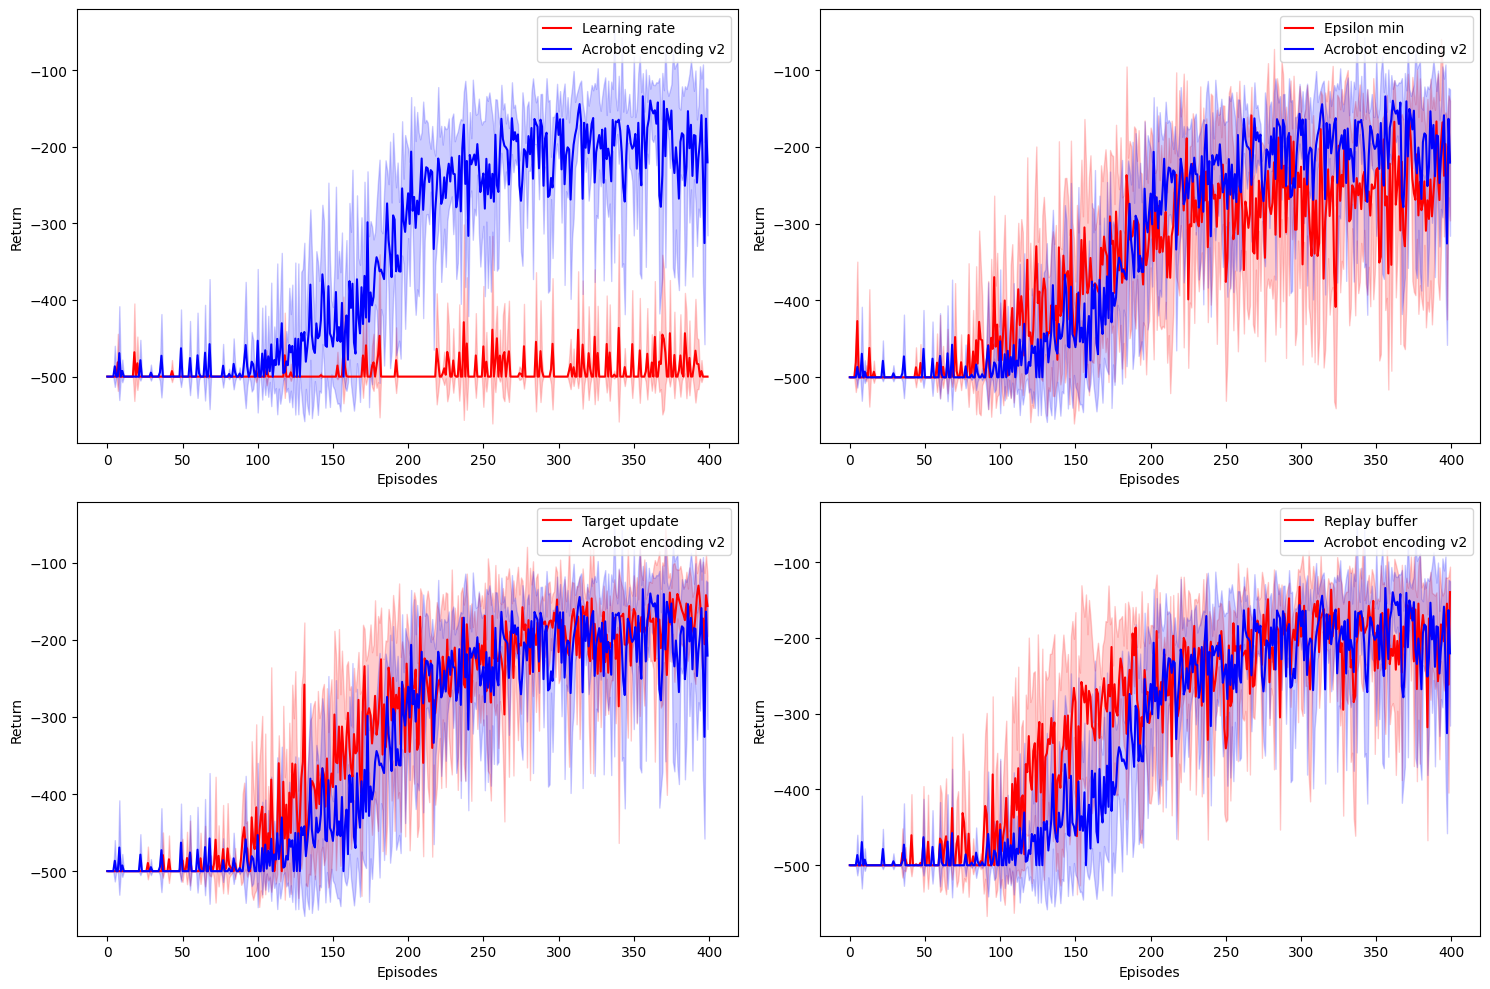

In [9]:
fig, axs = plt.subplots(2,2, figsize=(15,10), tight_layout=True)

axs[0,0].plot(learning_rate_mean,color = "red", label="Learning rate")
axs[0,0].fill_between(np.arange(len(learning_rate_mean)), learning_rate_mean - learning_rate_std, learning_rate_mean + learning_rate_std,color = "red", alpha=0.2)
axs[0,0].plot(acrobot_encoding_v2_mean,color = "blue", label="Acrobot encoding v2")
axs[0,0].fill_between(np.arange(len(acrobot_encoding_v2_mean)), acrobot_encoding_v2_mean - acrobot_encoding_v2_std, acrobot_encoding_v2_mean + acrobot_encoding_v2_std,color = "blue", alpha=0.2)
axs[0,0].legend()
axs[0,0].set_xlabel("Episodes")
axs[0,0].set_ylabel("Return")

axs[0,1].plot(epsilon_min_mean,color = "red", label="Epsilon min")
axs[0,1].fill_between(np.arange(len(epsilon_min_mean)), epsilon_min_mean - epsilon_min_std, epsilon_min_mean + epsilon_min_std,color = "red", alpha=0.2)
axs[0,1].plot(acrobot_encoding_v2_mean,color = "blue", label="Acrobot encoding v2")
axs[0,1].fill_between(np.arange(len(acrobot_encoding_v2_mean)), acrobot_encoding_v2_mean - acrobot_encoding_v2_std, acrobot_encoding_v2_mean + acrobot_encoding_v2_std,color = "blue", alpha=0.2)
axs[0,1].legend()
axs[0,1].set_xlabel("Episodes")
axs[0,1].set_ylabel("Return")

axs[1,0].plot(target_update_mean,color = "red", label="Target update")
axs[1,0].fill_between(np.arange(len(target_update_mean)), target_update_mean - target_update_std, target_update_mean + target_update_std,color = "red", alpha=0.2)
axs[1,0].plot(acrobot_encoding_v2_mean,color = "blue", label="Acrobot encoding v2")
axs[1,0].fill_between(np.arange(len(acrobot_encoding_v2_mean)), acrobot_encoding_v2_mean - acrobot_encoding_v2_std, acrobot_encoding_v2_mean + acrobot_encoding_v2_std,color = "blue", alpha=0.2)
axs[1,0].legend()
axs[1,0].set_xlabel("Episodes")
axs[1,0].set_ylabel("Return")

axs[1,1].plot(replay_buffer_mean,color = "red", label="Replay buffer")
axs[1,1].fill_between(np.arange(len(replay_buffer_mean)), replay_buffer_mean - replay_buffer_std, replay_buffer_mean + replay_buffer_std,color = "red", alpha=0.2)
axs[1,1].plot(acrobot_encoding_v2_mean,color = "blue", label="Acrobot encoding v2")
axs[1,1].fill_between(np.arange(len(acrobot_encoding_v2_mean)), acrobot_encoding_v2_mean - acrobot_encoding_v2_std, acrobot_encoding_v2_mean + acrobot_encoding_v2_std,color = "blue", alpha=0.2)
axs[1,1].legend()
axs[1,1].set_xlabel("Episodes")
axs[1,1].set_ylabel("Return")

plt.show()

First, the learning rate change clearly did not help at all, as the model learned nothing. The epsilon_min change seems to also get a worse performance than the original model, probably because maybe the model is exploiting too much and not exploring as much. The target_network_update_freq change seems to have a similar performance to the original model. Finally, the replay_memory_size change seems to have a little bit of a better performance than the original model, as it learns a little bit quicker.

In [10]:
performance_learning_rate = auc(learning_rate_return)
performance_epsilon_min = auc(epsilon_min_return)
performance_target_update = auc(target_update_return)
performance_replay_buffer = auc(replay_buffer_return)

performance_models_2 = [performance_acrobot_encoding_v2, performance_learning_rate, performance_epsilon_min, performance_target_update, performance_replay_buffer]
models_names = ["Original", "Learning rate", "Epsilon min", "Target update", "Replay buffer"]
performance_models_sorted = np.sort(performance_models_2)
models_names_sorted = [models_names[i] for i in np.argsort(performance_models_2)]

for i in range(len(performance_models_sorted)):
    print(models_names_sorted[i], performance_models_sorted[i])


Replay buffer 0.62532
Target update 0.6336009999999999
Original 0.670557
Epsilon min 0.7030185000000001
Learning rate 0.9857370000000001


# 3) Skolik and Lockwood Models

Finally, we simply replaced the UQC model for the Skolik and Lockwood models, keeping everything else the same, with acrobot-encodingv2. The results are shown below:

In [11]:
skolik_path = "../../results/acrobot_best/acrobot_best1_with_acrobot_encodingv2_skolik"
lock_path = "../../results/acrobot_best/acrobot_best1_with_acrobot_encodingv2_lock"
skolik = Analysis(skolik_path)
lock = Analysis(lock_path)

In [12]:
skolik_return = skolik.get_rewards()
lock_return = lock.get_rewards()

skolik_mean = np.mean(skolik_return, axis=0)
lock_mean = np.mean(lock_return, axis=0)

skolik_std = np.std(skolik_return, axis=0)
lock_std = np.std(lock_return, axis=0)

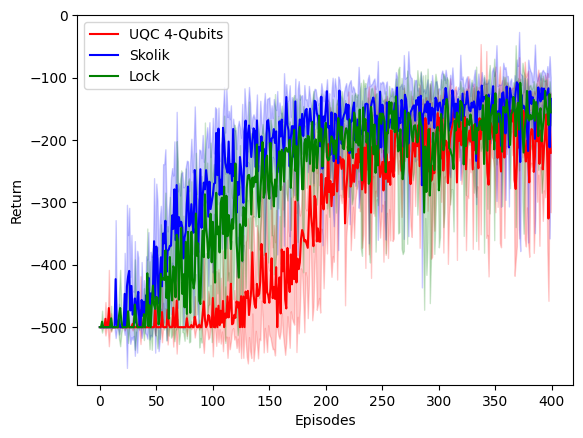

In [13]:
plt.plot(acrobot_encoding_v2_mean,color = "red", label="UQC 4-Qubits")
plt.fill_between(np.arange(len(acrobot_encoding_v2_mean)), acrobot_encoding_v2_mean - acrobot_encoding_v2_std, acrobot_encoding_v2_mean + acrobot_encoding_v2_std,color = "red", alpha=0.2)
plt.plot(skolik_mean,color = "blue", label="Skolik")
plt.fill_between(np.arange(len(skolik_mean)), skolik_mean - skolik_std, skolik_mean + skolik_std,color = "blue", alpha=0.2)
plt.plot(lock_mean,color = "green", label="Lock")
plt.fill_between(np.arange(len(lock_mean)), lock_mean - lock_std, lock_mean + lock_std,color = "green", alpha=0.2)
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.show()



Clearly, the Skolik and Lockwood models perform better than the UQC model, especially the Skolik models, which is interesting.

In [14]:
uqc_4qubits_mean_gradients, uqc_4qubits_variance_gradients, uqc_4qubits_max_gradients, uqc_4qubits_max_index, uqc_4qubits_min_gradients, uqc_4qubits_min_index = acrobot_encoding_v2.calculate_mean_variance_gradients(return_max = True, return_min = True)
skolik_mean_gradients, skolik_variance_gradients, skolik_max_gradients, skolik_max_index, skolik_min_gradients, skolik_min_index = skolik.calculate_mean_variance_gradients(return_max = True, return_min = True)
lock_mean_gradients, lock_variance_gradients, lock_max_gradients, lock_max_index, lock_min_gradients, lock_min_index = lock.calculate_mean_variance_gradients(return_max = True, return_min = True)

In [15]:
uqc_4qubits_mean_gradients_smoothed = pd.Series(uqc_4qubits_mean_gradients).rolling(250).mean()
skolik_mean_gradients_smoothed = pd.Series(skolik_mean_gradients).rolling(250).mean()
lock_mean_gradients_smoothed = pd.Series(lock_mean_gradients).rolling(250).mean()

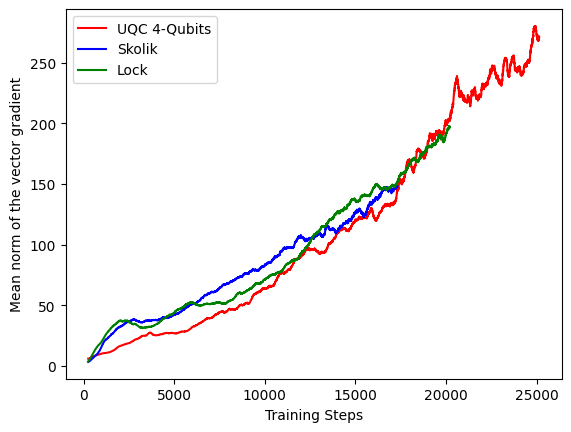

In [18]:
plt.plot(uqc_4qubits_mean_gradients_smoothed,color = "red", label="UQC 4-Qubits")
plt.plot(skolik_mean_gradients_smoothed,color = "blue", label="Skolik")
plt.plot(lock_mean_gradients_smoothed,color = "green", label="Lock")
plt.legend()
plt.xlabel("Training Steps")
plt.ylabel("Mean norm of the vector gradient")
plt.show()

In [17]:
uqc_parameters = acrobot_encoding_v2.get_parameters_relative_change()
skolik_parameters = skolik.get_parameters_relative_change()
lock_parameters = lock.get_parameters_relative_change()